In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
! pip install rawpy

     |████████████████████████████████| 1.7MB 10.1MB/s 


In [ ]:
! pip install colour-science

     |████████████████████████████████| 2.1MB 8.7MB/s 


In [ ]:
from image_fetch import get_path, read_raw, get_color_card
f2_dir = get_path('/content/drive/My Drive/Fish_pics/')

Root:/content/drive/My Drive/Fish_pics/
Number of fish: 107, Number of pictures: 4232


In [ ]:
fish_not_done = ['8','40','47','50','60','72','85','89','110']

In [ ]:
is_index = f2_dir.path.apply(lambda x:x[34:].split('/')[0] in fish_not_done)
run_index = is_index[is_index].index

In [ ]:
f2_dir.path[run_index].apply(lambda x:x[34:].split('/')[0]).unique()

array(['110', '40', '47', '50', '60', '8', '72', '85', '89'], dtype=object)

In [ ]:
def is_contained(a, b):
  x, y = contour_centroid(a)

  x_min_b =  min([sub[0] for sub in b])
  x_max_b = max([sub[0] for sub in b])
  y_min_b =  min([sub[1] for sub in b])
  y_max_b = max([sub[1] for sub in b])

  return x >= x_min_b and y >= y_min_b and x <= x_max_b and y <= y_max_b
def x_gap(patches):
  return [max([sub[0] for sub in patch]) - min([sub[0] for sub in patch]) for patch in patches]
def y_gap(patches):
  return [max([sub[1] for sub in patch]) - min([sub[1] for sub in patch]) for patch in patches]

In [ ]:
from color_checker import *
from color_calibration import *
def calibration_model(path):
  img = read_raw(path)
  if len(img) == 0:
    return None, None
  card, patches, checker = get_color_card(img) 
  if len(card) == 1:
    return None, None
  try:
    changed_img = as_8_bit_BGR_image(adjust_image(img, WORKING_WIDTH))
    # get the patches within the checker
    patches_in_checker = []
    for patch in patches:
      if is_contained(patch, checker):
        patches_in_checker.append(patch)
    # get the unconnected patches 
    patch_x_gap = x_gap(patches_in_checker)
    patch_y_gap = y_gap(patches_in_checker)
    x_gap_avg = sum(patch_x_gap)/len(patch_x_gap)
    y_gap_avg = sum(patch_y_gap)/len(patch_y_gap)
    selected_patches = []
    for i in range(len(patch_x_gap)):
      if patch_x_gap[i] < 1.2*x_gap_avg and patch_y_gap[i] < 1.2*y_gap_avg:
        selected_patches.append(patches_in_checker[i])
    # change the x and y pixel
    changed_patches = np.array([[[cell[1],cell[0]] for cell in patch] for patch in selected_patches])

    # calibration part
    from sklearn.cluster import DBSCAN
    min_eps=min(x_gap_avg, y_gap_avg)
    clustering = DBSCAN(eps=int(min_eps/6), min_samples=2).fit(np.array([contour_centroid(patch) for patch in changed_patches])[:,0].reshape(-1,1))
    center,result,labels=CompleteCard([contour_centroid(patch) for patch in changed_patches]
                                  ,[changed_img[int(contour_centroid(patch)[0])][int(contour_centroid(patch)[1])] for patch in changed_patches]
                                  ,changed_img,clustering.labels_)
    #determine which one of four color cards we should use
    color_card=DetermineColorCard(center,result,labels)
    if color_card == None:
      return None, None
    else:
      #label the location of each color patch in color card
      location=PatchLabel(center,labels)
      card_res=[]
      for i in location:
        if x_gap([checker]) < y_gap([checker]):
          first, second = i.split('_')[1], i.split('_')[0]
          if first+'_'+second not in color_card:
            return None, None
          card_res.append(color_card[first+'_'+second])
      # PLS Regression
      from sklearn.cross_decomposition import PLSRegression
      pls = PLSRegression(n_components=3)
      pls.fit(result, card_res)
      score = pls.score(result, card_res)
      if score<0.95: return None, None
      from sklearn.metrics import mean_squared_error
      import math
      pls_result = pls.predict(result)
      return pls, math.sqrt(mean_squared_error(pls_result, card_res))
      
  except ValueError:
    return None, None

In [ ]:
model = []
rmse = []
from tqdm import tqdm
for i in tqdm(range(200)):
  _model, _rmse = calibration_model(f2_dir.path[i])
  if _model != None:
    model.append(_model)
    rmse.append(_rmse)
    break


  0%|          | 1/200 [00:03<10:30,  3.17s/it]/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
  0%|          | 1/200 [00:06<20:59,  6.33s/it]


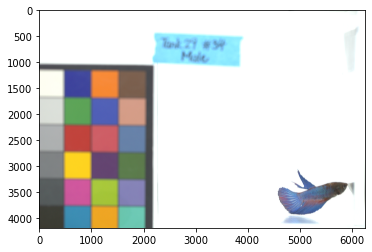

In [ ]:
calibrated_image = read_raw(f2_dir.path[1500])
for cell in calibrated_image:
    tt = model[0].predict(cell[:])
    tt[tt > 255] = 255
    tt[tt < 0] = 0
    cell[:] = tt
plt.imshow(calibrated_image)

In [ ]:
from color_checker import *
from color_calibration import *
def calibration_compare(path, model):
  img = read_raw(path)
  card, patches, checker = get_color_card(img) 
  if len(card) == 1:
    return None, None
  try:
    changed_img = as_8_bit_BGR_image(adjust_image(img, WORKING_WIDTH))
    # get the patches within the checker
    patches_in_checker = []
    for patch in patches:
      if is_contained(patch, checker):
        patches_in_checker.append(patch)
    # get the unconnected patches 
    patch_x_gap = x_gap(patches_in_checker)
    patch_y_gap = y_gap(patches_in_checker)
    x_gap_avg = sum(patch_x_gap)/len(patch_x_gap)
    y_gap_avg = sum(patch_y_gap)/len(patch_y_gap)
    selected_patches = []
    for i in range(len(patch_x_gap)):
      if patch_x_gap[i] < 1.2*x_gap_avg and patch_y_gap[i] < 1.2*y_gap_avg:
        selected_patches.append(patches_in_checker[i])
    # change the x and y pixel
    changed_patches = np.array([[[cell[1],cell[0]] for cell in patch] for patch in selected_patches])

    # calibration part
    from sklearn.cluster import DBSCAN
    min_eps=min(x_gap_avg, y_gap_avg)
    clustering = DBSCAN(eps=int(min_eps/6), min_samples=2).fit(np.array([contour_centroid(patch) for patch in changed_patches])[:,0].reshape(-1,1))
    center,result,labels=CompleteCard([contour_centroid(patch) for patch in changed_patches]
                                  ,[changed_img[int(contour_centroid(patch)[0])][int(contour_centroid(patch)[1])] for patch in changed_patches]
                                  ,changed_img,clustering.labels_)
    #determine which one of four color cards we should use
    color_card=DetermineColorCard(center,result,labels)
    if color_card == None:
      return None, None
    else:
      #label the location of each color patch in color card
      location=PatchLabel(center,labels)
      card_res=[]
      for i in location:
        if x_gap([checker]) < y_gap([checker]):
          first, second = i.split('_')[1], i.split('_')[0]
          if first+'_'+second not in color_card:
            return None, None
          card_res.append(color_card[first+'_'+second])
      # PLS Regression
      from sklearn.cross_decomposition import PLSRegression
      pls = PLSRegression(n_components=3)
      pls.fit(result, card_res)
      score = pls.score(result, card_res)
      if score<0.95: return None, None
      from sklearn.metrics import mean_squared_error
      import math
      pls_result = pls.predict(result)
      pls_model_result = model.predict(result)
      return math.sqrt(mean_squared_error(pls_result, card_res)), math.sqrt(mean_squared_error(pls_model_result, card_res))
      
  except ValueError:
    return None, None

In [ ]:
rmse_pls = []
rmse_model = []
from tqdm import tqdm
for i in tqdm(range(200)):
  r1, r2 = calibration_compare(f2_dir.path[i], model)
  if r1 != None:
    rmse_pls.append(r1)
    rmse_model.append(r2)

  0%|          | 1/200 [00:03<10:45,  3.25s/it]/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
  4%|▍         | 9/200 [00:29<10:17,  3.23s/it]/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with

In [ ]:
np.dot(np.array([123,123,123]),model.coef_)

array([ 6775.19885326,  6455.67763946,  7290.92637469])

In [ ]:
import pandas as pd
pd.DataFrame([rmse_pls,rmse_model]).T

,0,1
0,8.652803,17.650750
1,8.183632,11.648371
2,8.817888,12.451036
3,8.788758,10.462823
4,8.511433,14.717227
5,8.591763,15.436544
6,8.795712,15.637823
7,10.855511,16.808917
8,9.956989,15.309231
9,9.069433,9.906555


In [ ]:
img = read_raw(f2_dir.path[1])
card, patches, checker = get_color_card(img) 

changed_img = as_8_bit_BGR_image(adjust_image(img, WORKING_WIDTH))
# get the patches within the checker
patches_in_checker = []
for patch in patches:
  if is_contained(patch, checker):
    patches_in_checker.append(patch)
# get the unconnected patches 
patch_x_gap = x_gap(patches_in_checker)
patch_y_gap = y_gap(patches_in_checker)
x_gap_avg = sum(patch_x_gap)/len(patch_x_gap)
y_gap_avg = sum(patch_y_gap)/len(patch_y_gap)
selected_patches = []
for i in range(len(patch_x_gap)):
  if patch_x_gap[i] < 1.2*x_gap_avg and patch_y_gap[i] < 1.2*y_gap_avg:
    selected_patches.append(patches_in_checker[i])
# change the x and y pixel
changed_patches = np.array([[[cell[1],cell[0]] for cell in patch] for patch in selected_patches])

# calibration part
from sklearn.cluster import DBSCAN
min_eps=min(x_gap_avg, y_gap_avg)
clustering = DBSCAN(eps=int(min_eps/6), min_samples=2).fit(np.array([contour_centroid(patch) for patch in changed_patches])[:,0].reshape(-1,1))
center,result,labels=CompleteCard([contour_centroid(patch) for patch in changed_patches]
                              ,[changed_img[int(contour_centroid(patch)[0])][int(contour_centroid(patch)[1])] for patch in changed_patches]
                              ,changed_img,clustering.labels_)
#determine which one of four color cards we should use
color_card=DetermineColorCard(center,result,labels)

#label the location of each color patch in color card
location=PatchLabel(center,labels)
card_res=[]
for i in location:
  if x_gap([checker]) < y_gap([checker]):
    first, second = i.split('_')[1], i.split('_')[0]
    card_res.append(color_card[first+'_'+second])
# PLS Regression
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression(n_components=3)
pls.fit(result, card_res)
score = pls.score(result, card_res)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [ ]:
score

0.97643193004709017

In [ ]:
pls.coef_

array([[  7.61092728e+01,  -3.61320054e+00,   3.13387476e-02],
       [ -1.90256970e+01,   5.41482759e+01,   4.40357862e+00],
       [ -2.45289082e+00,   2.02196112e+00,   5.58556800e+01]])

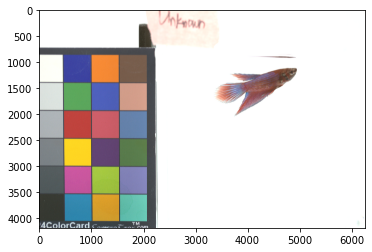

In [ ]:
calibrated_image = read_raw(f2_dir.path[18])
for cell in calibrated_image:
    tt = pls.predict(cell[:])
    tt[tt > 255] = 255
    tt[tt < 0] = 0
    cell[:] = tt
plt.imshow(calibrated_image)

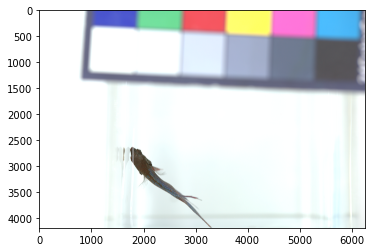

In [ ]:
calibrated_image = read_raw(f2_dir.path[210])
for cell in calibrated_image:
    tt = pls.predict(cell[:])
    tt[tt > 255] = 255
    tt[tt < 0] = 0
    cell[:] = tt
plt.imshow(calibrated_image)

In [ ]:
f2_dir.path[210]

'/content/drive/My Drive/F2 Pictures/5/IMG_5036.CR3'

In [ ]:
tt = read_raw('/content/drive/My Drive/F2 Pictures/RB_179/IMG_5488.CR3')
len(tt)

4180

In [ ]:
from color_checker import *
from color_calibration import *
import os
def calibration_one_fish(path):
  img = read_raw(path)
  if len(img)==0:
    return False
  card, patches, checker = get_color_card(img) 
  if len(card) == 1:
    return False
  try:
    changed_img = as_8_bit_BGR_image(adjust_image(img, WORKING_WIDTH))
    # get the patches within the checker
    patches_in_checker = []
    for patch in patches:
      if is_contained(patch, checker):
        patches_in_checker.append(patch)
    # get the unconnected patches 
    patch_x_gap = x_gap(patches_in_checker)
    patch_y_gap = y_gap(patches_in_checker)
    x_gap_avg = sum(patch_x_gap)/len(patch_x_gap)
    y_gap_avg = sum(patch_y_gap)/len(patch_y_gap)
    selected_patches = []
    for i in range(len(patch_x_gap)):
      if patch_x_gap[i] < 1.2*x_gap_avg and patch_y_gap[i] < 1.2*y_gap_avg:
        selected_patches.append(patches_in_checker[i])
    # change the x and y pixel
    changed_patches = np.array([[[cell[1],cell[0]] for cell in patch] for patch in selected_patches])

    # calibration part
    from sklearn.cluster import DBSCAN
    min_eps=min(x_gap_avg, y_gap_avg)
    clustering = DBSCAN(eps=int(min_eps/6), min_samples=2).fit(np.array([contour_centroid(patch) for patch in changed_patches])[:,0].reshape(-1,1))
    center,result,labels=CompleteCard([contour_centroid(patch) for patch in changed_patches]
                                  ,[changed_img[int(contour_centroid(patch)[0])][int(contour_centroid(patch)[1])] for patch in changed_patches]
                                  ,changed_img,clustering.labels_)
    #determine which one of four color cards we should use
    color_card=DetermineColorCard(center,result,labels)
    if color_card == None:
      return False
    else:
      #label the location of each color patch in color card
      location=PatchLabel(center,labels)
      card_res=[]
      for i in location:
        if x_gap([checker]) < y_gap([checker]):
          first, second = i.split('_')[1], i.split('_')[0]
          if first+'_'+second not in color_card:
            return False
          card_res.append(color_card[first+'_'+second])
      # PLS Regression
      from sklearn.cross_decomposition import PLSRegression
      pls = PLSRegression(n_components=3)
      pls.fit(result, card_res)
      score = pls.score(result, card_res)
      if score<0.95: return False

      calibrated_image = img.copy()
      for cell in calibrated_image:
          tt = pls.predict(cell[:])
          tt[tt > 255] = 255
          tt[tt < 0] = 0
          cell[:] = tt
      img_t =  cv2.cvtColor(calibrated_image, cv2.COLOR_RGB2BGR)
      index = path[34:].find('/')
      folder_name = path[34:][:index]
      file_name = '_'.join(map(str, path[34:][index+1:].split('/'))).split('.')[0]
      name_score = str(round(score,2)).split('.')[1]

      if not os.path.exists('/content/drive/My Drive/fishpics_final_result/'+folder_name):
        os.makedirs('/content/drive/My Drive/fishpics_final_result/'+folder_name)
      cv2.imwrite('/content/drive/My Drive/fishpics_final_result/'+folder_name+'/'+file_name+'_'+name_score+'.png', img_t)

      return True
  except ValueError:
    return False

In [ ]:
len(run_index)

601

Dont forget to Run this！！！

In [ ]:
path = '2/H/4887.jpg'
index = path.find('/')
'_'.join(map(str, path[index+1:].split('/'))).split('.')[0]

'H_4887'

In [ ]:
def output(path, model, score=None):
  img = read_raw(path)
  calibrated_image = img.copy()
  for cell in calibrated_image:
      tt = model.predict(cell[:])
      tt[tt > 255] = 255
      tt[tt < 0] = 0
      cell[:] = tt
  img_t =  cv2.cvtColor(calibrated_image, cv2.COLOR_RGB2BGR)
  index = path[34:].find('/')
  folder_name = path[34:][:index]
  file_name = '_'.join(map(str, path[34:][index+1:].split('/'))).split('.')[0]
  name_score = str(round(score,2)).split('.')[1] if score !=None else ''

  if not os.path.exists('/content/drive/My Drive/fishpics_final_result/'+folder_name):
    os.makedirs('/content/drive/My Drive/fishpics_final_result/'+folder_name)
  cv2.imwrite('/content/drive/My Drive/fishpics_final_result/'+folder_name+'/'+file_name+'_'+name_score+'.png', img_t)

In [ ]:
path = f2_dir.path[run_index[0]]
index = path[34:].find('/')
folder_name = path[34:][:index]
file_name = '_'.join(map(str, path[34:][index+1:].split('/'))).split('.')[0]

In [ ]:
path[34:]

'110/110_IMG_2540.CR3'

In [ ]:
rb_dir.path[8081+374+129]

'/content/drive/My Drive/F2 Pictures/RB_140/IMG_5849.CR3'

In [ ]:
rb_dir.path.apply(lambda x:x[36:].split('/')[0]).unique()

array(['RB_24', 'RB_124', 'RB_133', 'RB_125', 'RB_123', 'RB_131', 'RB_129',
       'RB_130', 'RB_128', 'RB_127', 'RB_126', 'RB_135', 'RB_179',
       'RB_140', 'RB_139', 'RB_183', 'RB_155', 'RB_154', 'RB_153',
       'RB_150', 'RB_152', 'RB_151', 'RB_149', 'RB_148', 'RB_185',
       'RB_186', 'RB_188', 'RB_203 (1)', 'RB_204', 'RB_205', 'RB_206',
       'RB_207', 'RB_207b', 'RB_208', 'RB_209', 'RB_210', 'RB_211',
       'RB_212', 'RB_213', 'RB_214', 'RB_215', 'RB_216', 'RB_217',
       'RB_192', 'RB_193', 'RB_191', 'RB_194', 'RB_195', 'RB_196',
       'RB_197', 'RB_198', 'RB_167', 'RB_170', 'RB_169', 'RB_171',
       'RB_172', 'RB_168', 'RB_173', 'RB_174', 'RB_156 (1)', 'RB_157 (1)',
       'RB_158 (1)', 'RB_159', 'RB_160', 'RB_161', 'RB_162', 'RB_163',
       'RB_164', 'RB_165', 'RB_166', 'RB_141', 'RB_136', 'RB_142',
       'RB_137', 'RB_143', 'RB_144', 'RB_145', 'RB_146', 'RB_147',
       'RB_158', 'RB_157', 'RB_156', 'RB_199 (1)', 'RB_200 (1)',
       'RB_201 (1)', 'RB_202 (1)', 'RB

In [ ]:
from tqdm import tqdm
for i in tqdm(range(len(run_index))):
  try:
    if calibration_one_fish(f2_dir.path[run_index[i]])==False:
      output(f2_dir.path[run_index[i]], model[0], score=None)
  except ValueError:
    continue



  0%|          | 0/354 [00:00<?, ?it/s]

  0%|          | 1/354 [00:09<53:29,  9.09s/it]

  1%|          | 2/354 [00:18<53:35,  9.14s/it]

  1%|          | 3/354 [00:27<53:09,  9.09s/it]

  1%|          | 4/354 [00:36<53:14,  9.13s/it]

  1%|▏         | 5/354 [00:45<52:35,  9.04s/it]

  2%|▏         | 6/354 [00:54<52:22,  9.03s/it]

  2%|▏         | 7/354 [01:03<52:07,  9.01s/it]

  2%|▏         | 8/354 [01:12<51:31,  8.94s/it]

  3%|▎         | 9/354 [01:22<53:19,  9.27s/it]

  3%|▎         | 10/354 [01:32<55:34,  9.69s/it]

  3%|▎         | 11/354 [01:43<56:33,  9.89s/it]

  3%|▎         | 12/354 [01:53<57:19, 10.06s/it]

  4%|▎         | 13/354 [02:04<57:50, 10.18s/it]

  4%|▍         | 14/354 [02:15<59:22, 10.48s/it]

  4%|▍         | 15/354 [02:25<58:55, 10.43s/it]

  5%|▍         | 16/354 [02:36<59:08, 10.50s/it]

  5%|▍         | 17/354 [02:46<58:48, 10.47s/it]

  5%|▌         | 18/354 [02:57<58:27, 10.44s/it]

  5%|▌         | 19/354 [03:07<58:36, 10.50s/it]

  6%|▌         |

# Run the Code Before

In [ ]:
fail

1663

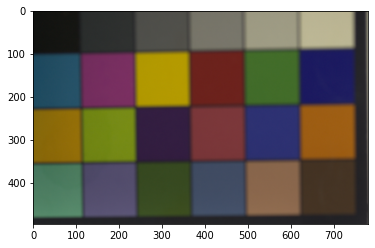

In [ ]:
from image_fetch import get_path, read_raw, get_color_card
img = read_raw(f2_dir.path[9])
card, patches,checker = get_color_card(img)
plt.imshow(card)

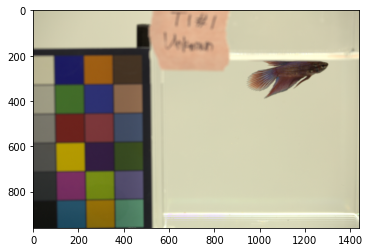

In [ ]:
from color_checker import *
changed_img = as_8_bit_BGR_image(adjust_image(img, WORKING_WIDTH))
plt.imshow(changed_img)

In [ ]:
# if x_gap([checker]) < y_gap([checker]):
#   patches = [[[cell[1], changed_img.shape[0]-cell[0]] for cell in patch] for patch in patches]
#   checker = [[patch[1], changed_img.shape[0]-patch[0]] for patch in checker]
#   changed_img = cv2.rotate(changed_img, cv2.ROTATE_90_CLOCKWISE)
# plt.imshow(changed_img)

In [ ]:
patches_in_checker = []
for patch in patches:
  if is_contained(patch, checker):
    patches_in_checker.append(patch)
len(patches_in_checker)

20

In [ ]:
patch_x_gap = x_gap(patches_in_checker)
patch_y_gap = y_gap(patches_in_checker)
x_gap_avg = sum(patch_x_gap)/len(patch_x_gap)
y_gap_avg = sum(patch_y_gap)/len(patch_y_gap)
selected_patches = []
for i in range(len(patch_x_gap)):
  if patch_x_gap[i] < 1.2*x_gap_avg and patch_y_gap[i] < 1.2*y_gap_avg:
    selected_patches.append(patches_in_checker[i])
len(selected_patches)

17

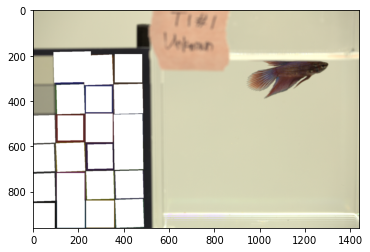

In [ ]:
import numpy as np
image2 = changed_img.copy()
#for cluster in clusters:
for patch in patches:
  #for j in range(len(swatches[i])-1):
    #cv2.line(image, tuple(swatches[i][j]), tuple(swatches[i][j+1]), (255,255,255), 10)
  #cv2.fillPoly(image2, pts=[swatches[i]], color=tuple([random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]))
  cv2.fillPoly(image2, pts=[np.array(patch)], color=(255, 255, 255))
plt.imshow(image2)

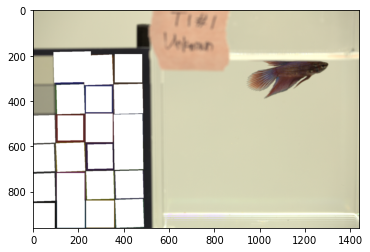

In [ ]:
import numpy as np
image2 = changed_img.copy()
#for cluster in clusters:
for patch in patches_in_checker:
  #for j in range(len(swatches[i])-1):
    #cv2.line(image, tuple(swatches[i][j]), tuple(swatches[i][j+1]), (255,255,255), 10)
  #cv2.fillPoly(image2, pts=[swatches[i]], color=tuple([random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]))
  cv2.fillPoly(image2, pts=[patch], color=(255, 255, 255))
plt.imshow(image2)

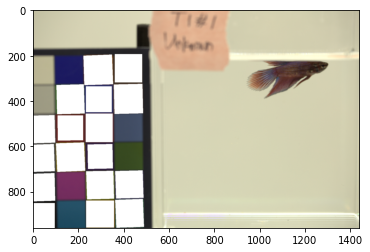

In [ ]:
import numpy as np
image2 = changed_img.copy()
#for cluster in clusters:
for patch in selected_patches:
  #for j in range(len(swatches[i])-1):
    #cv2.line(image, tuple(swatches[i][j]), tuple(swatches[i][j+1]), (255,255,255), 10)
  #cv2.fillPoly(image2, pts=[swatches[i]], color=tuple([random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]))
  cv2.fillPoly(image2, pts=[patch], color=(255, 255, 255))
plt.imshow(image2)

In [ ]:
changed_patches = np.array([[[cell[1],cell[0]] for cell in patch] for patch in selected_patches])

In [ ]:
from sklearn.cluster import DBSCAN
min_eps=min(x_gap_avg, y_gap_avg)
clustering = DBSCAN(eps=int(min_eps/6), min_samples=2).fit(np.array([contour_centroid(patch) for patch in changed_patches])[:,0].reshape(-1,1))

In [ ]:
clustering.labels_

array([0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5])

In [ ]:
def FindBlackLocation(center,result,label):
    black_row=label[np.argmin(np.array(result).sum(axis=1))]
    black_col=center[np.argmin(np.array(result).sum(axis=1))][1]
    black_row_all_col=[center[x][1] for x in np.where(label==black_row)[0]]
    if min(black_row_all_col)==black_col:
        return str(black_row+1)+'_1'
    elif max(black_row_all_col)==black_col:
        return str(black_row+1)+'_'+str(len(black_row_all_col))

In [ ]:
from color_calibration import *
center,result,labels=CompleteCard([contour_centroid(patch) for patch in changed_patches]
                                  ,[changed_img[int(contour_centroid(patch)[0])][int(contour_centroid(patch)[1])] for patch in changed_patches]
                                  ,changed_img,clustering.labels_)

In [ ]:
len(labels)

24

In [ ]:
FindBlackLocation(center,result,labels)

'1_1'

In [ ]:
location

0     1_1
1     1_2
2     1_3
3     1_4
4     2_1
5     2_2
6     2_3
7     2_4
8     3_1
9     3_3
10    3_2
11    3_4
12    4_1
13    4_2
14    4_3
15    4_4
16    5_1
17    5_3
18    5_2
19    5_4
20    6_1
21    6_3
22    6_4
23    6_2
dtype: object

In [ ]:
#determine which one of four color cards we should use
color_card=DetermineColorCard(center,result,labels)
#label the location of each color patch in color card
location=PatchLabel(center,labels)
card_res=[]
for i in location:
  if x_gap([checker]) < y_gap([checker]):
    first, second = i.split('_')[1], i.split('_')[0]
    card_res.append(color_card[first+'_'+second])
#return location,color_card,result,card_res

In [ ]:
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression(n_components=3)
pls.fit(result, card_res)
pls.score(result, card_res)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.97820853043493672

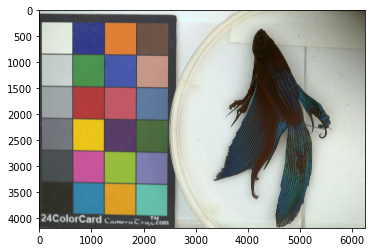

In [ ]:
calibrated_image = img.copy()
for cell in calibrated_image:
    tt = pls.predict(cell[:])
    tt[tt > 255] = 255
    tt[tt < 0] = 0
    cell[:] = tt
plt.imshow(calibrated_image)

In [ ]:
img_t =  cv2.cvtColor(calibrated_image, cv2.COLOR_RGB2BGR)
cv2.imwrite('/content/drive/My Drive/calibration_result/test4.jpeg', img_t)

True

In [ ]:
img_t = calibrated_image[:,:,::-1].transpose((2,0,1))

In [ ]:
 cv2.cvtColor(calibrated_image, cv2.COLOR_RGB2BGR)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ..., 
       [[152, 189, 195],
        [151, 189, 197],
        [154, 189, 199],
        ..., 
        [162, 201, 212],
        [161, 199, 212],
        [161, 199, 212]],

       [[152, 189, 197],
        [151, 192, 197],
        [154, 191, 202],
        ..., 
        [160, 202, 213],
        [160, 201, 214],
        [160, 199, 214]],

       [[152, 189, 199],
        [152, 191, 198],
        [154, 191, 200],
        ..., 
        [162, 201, 214],
        [160, 202, 211],
        [158, 200,

In [ ]:
def show_patch(patches, img):
  for patch in patches:
    cv2.fillPoly(img, pts=[patch], color=(255, 255, 255))
  return img

In [ ]:
def show_three_patch(patches, checker, img):
  changed_img = as_8_bit_BGR_image(adjust_image(img, WORKING_WIDTH))
  patches_in_checker = []
  for patch in patches:
    if is_contained(patch, checker):
      patches_in_checker.append(patch)

  patch_x_gap = x_gap(patches_in_checker)
  patch_y_gap = y_gap(patches_in_checker)
  x_gap_avg = sum(patch_x_gap)/len(patch_x_gap)
  y_gap_avg = sum(patch_y_gap)/len(patch_y_gap)
  selected_patches = []
  for i in range(len(patch_x_gap)):
    if patch_x_gap[i] < 1.2*x_gap_avg and patch_y_gap[i] < 1.2*y_gap_avg:
      selected_patches.append(patches_in_checker[i])
  image1, image2, image3 = changed_img.copy(), changed_img.copy(), changed_img.copy()
  return show_patch(patches, image1), show_patch(patches_in_checker, image2), show_patch(selected_patches, image3)

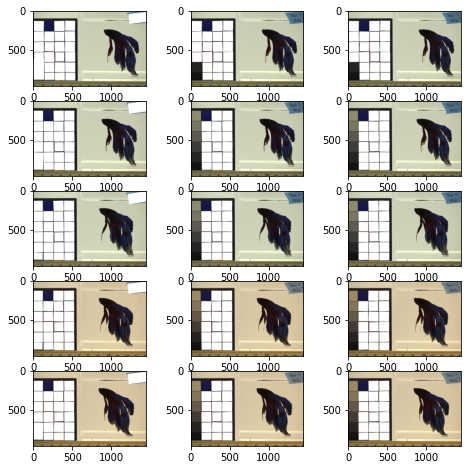

In [ ]:
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 5
for i in range(rows):
  img = read_raw(f2_dir.path[i])
  card, patches, checker = get_color_card(img)
  img1, img2, img3 = show_three_patch(patches, checker, img)
  fig.add_subplot(rows, columns, i*columns+1)
  plt.imshow(img1)
  fig.add_subplot(rows, columns, i*columns+2)
  plt.imshow(img2)
  fig.add_subplot(rows, columns, i*columns+3)
  plt.imshow(img3)
plt.show()

In [ ]:
len(image)

960

In [ ]:
image = img.copy()
image = as_8_bit_BGR_image(adjust_image(image, WORKING_WIDTH))

width, height = image.shape[1], image.shape[0]
maximum_area = width * height / SWATCHES
minimum_area = width * height / SWATCHES / SWATCH_MINIMUM_AREA_FACTOR

block_size = as_int(WORKING_WIDTH * 0.015)
block_size = block_size - block_size % 2 + 1

# Thresholding/Segmentation.
image_g = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#image_g = cv2.fastNlMeansDenoising(image_g, None, 10, 7, 21)
image_s = cv2.adaptiveThreshold(image_g, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                cv2.THRESH_BINARY, block_size, 3)
# Cleanup.
kernel = np.ones((3, 3), np.uint8)
image_c = cv2.erode(image_s, kernel, iterations=1)
image_c = cv2.dilate(image_c, kernel, iterations=1)

# Detecting contours.
contours, _hierarchy = cv2.findContours(image_c, cv2.RETR_TREE,
                                        cv2.CHAIN_APPROX_NONE)

# Filtering squares/swatches contours.
swatches = []
for contour in contours:
    curve = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True),
                              True)
    if minimum_area < cv2.contourArea(curve) < maximum_area and is_square(
            curve):
        swatches.append(
            as_int_array(cv2.boxPoints(cv2.minAreaRect(curve))))

# Clustering squares/swatches.
clusters = np.zeros(image.shape, dtype=np.uint8)
for swatch in [
        as_int_array(scale_contour(swatch, 1 + 1 / 3))
        for swatch in swatches
]:
    cv2.drawContours(clusters, [swatch], -1, [255] * 3, -1)
clusters = cv2.cvtColor(clusters, cv2.COLOR_RGB2GRAY)
clusters, _hierarchy = cv2.findContours(clusters, cv2.RETR_EXTERNAL,
                                        cv2.CHAIN_APPROX_NONE)
clusters = [
    as_int_array(
        scale_contour(cv2.boxPoints(cv2.minAreaRect(cluster)), 0.975))
    for cluster in clusters
]

# Filtering clusters using their aspect ratio.
filtered_clusters = []
for cluster in clusters[:]:
    rectangle = cv2.minAreaRect(cluster)
    width = max(rectangle[1][0], rectangle[1][1])
    height = min(rectangle[1][0], rectangle[1][1])
    ratio = width / height
    if ASPECT_RATIO * 5 /6 < ratio < ASPECT_RATIO * 4 / 3:
        filtered_clusters.append(cluster)
clusters = filtered_clusters

# Filtering swatches within cluster.
counts = []
for cluster in clusters:
    count = 0
    for swatch in swatches:
        if cv2.pointPolygonTest(cluster, contour_centroid(swatch),
                                False) == 1:
            count += 1
    counts.append(count)
counts = np.array(counts)
indexes = np.where(
    np.logical_and(counts >= SWATCHES * 0.5,
                    counts <= SWATCHES * 1.25))[0].tolist()

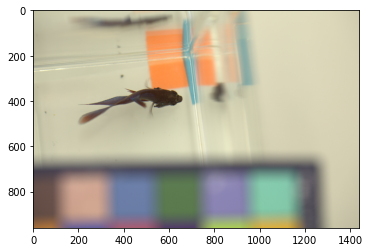

In [ ]:
plt.imshow(image)

In [ ]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped

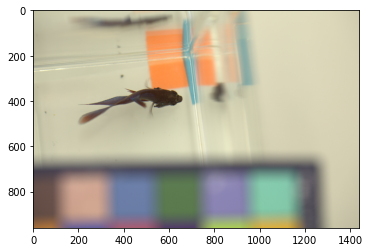

In [ ]:
import numpy as np
image2 = image.copy()
#for cluster in clusters:
for swatch in swatches:
  #for j in range(len(swatches[i])-1):
    #cv2.line(image, tuple(swatches[i][j]), tuple(swatches[i][j+1]), (255,255,255), 10)
  #cv2.fillPoly(image2, pts=[swatches[i]], color=tuple([random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]))
  cv2.fillPoly(image2, pts=[swatch], color=(255, 255, 255))
plt.imshow(image2)

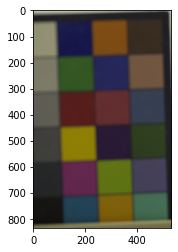

In [ ]:
temp = four_point_transform(image.copy(), clusters[0])
plt.imshow(temp)

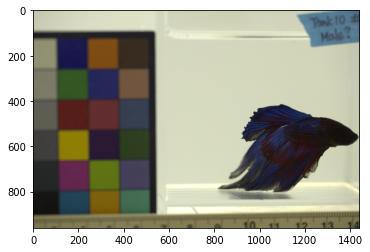

In [ ]:
plt.imshow(image)

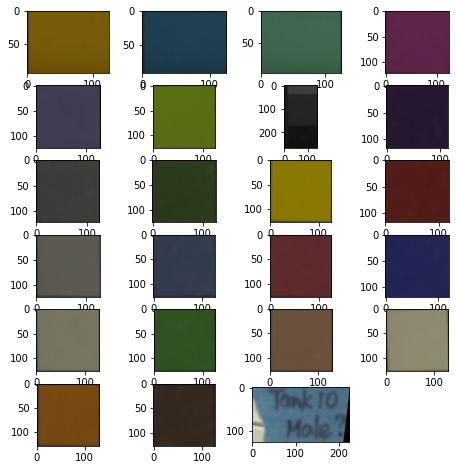

In [ ]:
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 6
for i in range(1, columns*rows +1):
    if i < 24:
      img = four_point_transform(image, swatches[i-1])
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)
plt.show()